In [ ]:
import torch

#Set CPU as default device
default_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Set GPU for BERT training if available
bert_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Default device for general processing: {default_device}")
print(f"Device for BERT training: {bert_device}")


Default device for general processing: cuda
Device for BERT training: cuda


# 📧 Phishing Email Detection System Using BERT

In this project, we aim to build a phishing email detection model using deep learning techniques, with a focus on the BERT (Bidirectional Encoder Representations from Transformers) architecture.

Phishing emails are deceptive messages designed to trick users into revealing sensitive information. As attackers increasingly use AI to craft convincing emails, traditional rule-based filters fall short. This motivates the need for a more intelligent, language-aware detection system.

We begin by loading and preprocessing real-world phishing and legitimate email datasets. After tokenizing the data, we will train and evaluate a fine-tuned BERT model, and compare its performance to a logistic regression baseline. Our objective is to build a model that accurately classifies emails as "phishing" or "safe" using language patterns and contextual understanding.





In [ ]:
from google.colab import userdata
#KaggkeAPIKey = userdata.get('KaggleAPIKey')

---

# Mounting the google drive
We have to mount the google drive seeing as the files for the datasets are stored there

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


---
# Cleaning Data across Datasets
Making all data sets consistent in labeling, data type and format:

1. "body": Holds the body of all emails.
2. "urls": Holds the boolean value for if a url is present or not (1: url, 0: no url)
3. "label": Holds the boolen value for if an email is Phishing or Safe (1: phishing, 0 not phishing)


- REMOVING UNPARSABLE/ ILLEGAL DATA
- You can view all data at "APS360_Final_Cleaned_Data" in shared folder

In [ ]:
!pip install xlsxwriter
!pip install pandas openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 12.1 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import re

#Folder with your CSVs
source_folder = '/content/drive/MyDrive/APS360 Notes/Datasets'
output_excel_path = os.path.join(source_folder, 'APS360_Final_Cleaned_Data.xlsx')

#Create the directory if it doesn't exist
os.makedirs(source_folder, exist_ok=True)

#Patterns to detect illegal Excel characters and ANSI sequences
ansi_pattern = re.compile(r'[\x1B\x1b]\[[0-9;]*[A-Za-z]|[0-9]+;[0-9]+[Hf]')
illegal_excel_chars = re.compile(r"[\x00-\x08\x0B-\x1F]")

#Function to check if a row contains illegal characters
def row_has_illegal_data(row):
    return any(
        ansi_pattern.search(str(cell)) or illegal_excel_chars.search(str(cell))
        for cell in row
    )

#Create ExcelWriter object
with pd.ExcelWriter(output_excel_path, engine='openpyxl') as writer:
    for filename in os.listdir(source_folder):
        if filename.endswith('.csv'):
            filepath = os.path.join(source_folder, filename)

            try:
                df = pd.read_csv(filepath, on_bad_lines='skip', encoding='utf-8', engine='python')
            except Exception as e:
                print(f"Skipping {filename} due to read error: {e}")
                continue

            #Drop rows with illegal characters
            df = df[~df.apply(row_has_illegal_data, axis=1)]

            #Clean and rename columns
            df.columns = [col.strip() for col in df.columns]
            col_map = {}
            for col in df.columns:
                if col.lower() in ['email text', 'text']:
                    col_map[col] = 'body'
                elif col.lower() == 'email type':
                    col_map[col] = 'label'
            df = df.rename(columns=col_map)

            #Add 'urls' column if missing
            if 'urls' not in df.columns and 'body' in df.columns:
                df['urls'] = df['body'].astype(str).apply(lambda x: 1 if 'http' in x else 0)

            #Keep only ['body', 'urls', 'label']
            keep_cols = [col for col in ['body', 'urls', 'label'] if col in df.columns]
            df = df[keep_cols]

            #Write sheet to Excel
            sheet_name = os.path.splitext(filename)[0][:31]
            try:
                df.to_excel(writer, sheet_name=sheet_name, index=False)
            except Exception as e:
                print(f"Failed to write sheet for {filename}: {e}")

print(f"Done! Cleaned Excel file saved at:\n{output_excel_path}")

Done! Cleaned Excel file saved at:
/content/drive/MyDrive/APS360 Notes/Datasets/APS360_Final_Cleaned_Data.xlsx


---
#Combine Data into One Large Dataset

- Takes all csv files and merges into one giant data set.
- Removes empty and null rows.
- Randomly shuffles and rearranges data.
- Makes sure that "label" and "urls" data is numerical later processing

In [ ]:
#This is a function Force string/int labels to integer 0 or 1
#Will be used later in combination (for cleaning purposes)

def clean_numerics(x):
    x_str = str(x).strip().lower()
    if x_str in ['1', 'phishing email']:
        return 1
    elif x_str in ['0', 'safe email']:
        return 0
    else:
        return 0

In [ ]:
#Load all sheets
all_sheets = pd.read_excel(output_excel_path, sheet_name=None)

#Concatenate all sheets into one DataFrame
phishing_df = pd.concat(all_sheets.values(), ignore_index=True)

#Drop rows with missing values (if any)
phishing_df = phishing_df.dropna()

#Shuffle dataset
phishing_df = phishing_df.sample(frac=1, random_state=42).reset_index(drop=True)

#Checks that this data is numerical
phishing_df['label'] = phishing_df['label'].apply(clean_numerics)
phishing_df['urls'] = phishing_df['urls'].apply(clean_numerics)


---
#Clean and Set New Testing Data

- Organizes Manually Collected never before seen data for testing

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='xlsxwriter')

# Load the two CSV files
df1 = pd.read_csv('/content/drive/MyDrive/APS360 Notes/Datasets/New_Data/Testing_Phishing_Dataset_Real.csv',encoding='ISO-8859-1')
df2 = pd.read_csv('/content/drive/MyDrive/APS360 Notes/Datasets/New_Data/Testing_Phishing_Dataset_AI.csv', encoding='ISO-8859-1')

# Clean column names (remove leading/trailing whitespace)
df1.columns = df1.columns.str.strip()
df2.columns = df2.columns.str.strip()
df1.rename(columns={'url': 'urls'}, inplace=True)
df2.rename(columns={'url': 'urls'}, inplace=True)

# Concatenate them
combined = pd.concat([df1, df2], ignore_index=True)
# Drop rows where label is NaN
combined = combined.dropna(subset=['label'])
combined = combined.dropna(subset=['urls'])
combined = combined.dropna(subset=['body'])
# Convert label column to int
combined['label'] = combined['label'].astype(int)


# Save to Excel
combined.to_excel('/content/drive/MyDrive/APS360 Notes/Datasets/New_Data/Final_Testing_Data.xlsx', index=False)
output_excel_path = '/content/drive/MyDrive/APS360 Notes/Datasets/New_Data/Final_Testing_Data.xlsx'

# Do nothing, or print something meaningful
print(f"Done! Cleaned Excel file saved at:\n /content/drive/MyDrive/APS360 Notes/Datasets/New_Data/Final_Testing_Data.xlsx")


Done! Cleaned Excel file saved at:
 /content/drive/MyDrive/APS360 Notes/Datasets/New_Data/Final_Testing_Data.xlsx


In [ ]:
#Load all sheets
test_sheets = pd.read_excel(output_excel_path, sheet_name=None)

#Concatenate all sheets into one DataFrame
test_df = pd.concat(test_sheets.values(), ignore_index=True)

#Shuffle dataset
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

#Drop rows with NaN in the body column from test set
test_df = test_df.dropna(subset=['body'])
test_df = test_df.dropna(subset=['urls'])
test_df = test_df.dropna(subset=['label'])

test_df= pd.concat([test_df] * 2, ignore_index=True)

#Show the first 5 rows
print(test_df.head())


                                                body  urls  label
0  Thank you for your recent purchase. If there a...     0      1
1  Please join us for our branch meeting being he...     0      0
2  Thank you for your recent purchase. If there a...     0      1
3  Hello, we've flagged a few inconsistencies in ...     0      1
4  Thank you for electronically signing the Adult...     1      0


---
#Split Tensor Data into Training Validation and Testing Datasets

- Randomly split the encoded email data into 70% training, 15% validation, and 15% test sets.
- Each split contains input tensors from the tokenization (input_ids, attention_mask) along with corresponding labels and URL indicators (from phishing_df ).
- This prepares the data for use in training and evaluating an AI classification model.




In [ ]:
from sklearn.model_selection import train_test_split
import torch

#Sizes
phishing_len = len(phishing_df)
test_len = len(test_df)          #1348
total_len = phishing_len + test_len  #68474

#Desired split counts
train_size = int(0.7 * total_len)
val_size = int(0.15 * total_len)
test_size = total_len - train_size - val_size

#Make sure phishing_df has enough samples for train + val
if phishing_len < train_size + val_size:
    raise ValueError("phishing_df doesn't have enough samples for train + val splits.")

#Calculate leftover phishing samples for test
phishing_test_size = phishing_len - train_size - val_size  #leftover phishing samples for test set

#Check test size feasibility
if phishing_test_size + test_len != test_size:
    raise ValueError(f"Test set size mismatch! Expected {test_size}, but got phishing leftover + test_df = {phishing_test_size + test_len}")

#Split phishing_df indices into train, val, and test leftover
all_indices = list(range(phishing_len))
train_val_idx, phishing_test_idx = train_test_split(
    all_indices, test_size=phishing_test_size, random_state=42)

#Split train_val_idx into train and val according to proportions
train_proportion = train_size / (train_size + val_size)
train_idx, val_idx = train_test_split(
    train_val_idx, test_size=1-train_proportion, random_state=42)

#Now create splits:

#Training set (only phishing_df)
train_bodies = phishing_df.loc[train_idx, 'body'].tolist()
train_urls = torch.tensor(phishing_df.loc[train_idx, 'urls'].tolist())
train_labels = torch.tensor(phishing_df.loc[train_idx, 'label'].tolist())

#Validation set (only phishing_df)
val_bodies = phishing_df.loc[val_idx, 'body'].tolist()
val_urls = torch.tensor(phishing_df.loc[val_idx, 'urls'].tolist())
val_labels = torch.tensor(phishing_df.loc[val_idx, 'label'].tolist())

#Testing set: leftover phishing_df + all test_df
phishing_test_bodies = phishing_df.loc[phishing_test_idx, 'body'].tolist()
phishing_test_urls = phishing_df.loc[phishing_test_idx, 'urls'].tolist()
phishing_test_labels = phishing_df.loc[phishing_test_idx, 'label'].tolist()

test_bodies = phishing_test_bodies + test_df['body'].tolist()
test_urls = torch.tensor(phishing_test_urls + test_df['urls'].tolist())
test_labels = torch.tensor(phishing_test_labels + test_df['label'].tolist())

#Print final stats:
print(f"Train size: {len(train_labels)} samples ({100*len(train_labels)/total_len:.2f}%)")
print(f"Validation size: {len(val_labels)} samples ({100*len(val_labels)/total_len:.2f}%)")
print(f"Test size: {len(test_labels)} samples ({100*len(test_labels)/total_len:.2f}%)")


#Total size of test set
test_total = len(test_labels)
phishing_test_count = len(phishing_test_labels)

#Print breakdown
print("\nTest set breakdown:")
print(f"- phishing_df: {phishing_test_count} samples ({100 * phishing_test_count / test_total:.2f}%)")
print(f"- test_df: {test_len} samples ({100 * test_len / test_total:.2f}%)")





Train size: 47929 samples (70.00%)
Validation size: 10271 samples (15.00%)
Test size: 10272 samples (15.00%)

Test set breakdown:
- phishing_df: 8926 samples (86.90%)
- test_df: 1346 samples (13.10%)


In [ ]:
# Combine both dataframes
full_df = pd.concat([phishing_df, test_df], ignore_index=True)

# Count total
N = len(full_df)

# Print statistics
print("Number of emails:", N)
print("\n")

print("Number of phishing emails:", full_df['label'].value_counts()[1])
print("Number of safe emails:", full_df['label'].value_counts()[0])
print("\n")

print("Number of emails with urls:", full_df['urls'].value_counts()[1])
print("Number of emails without urls:", full_df['urls'].value_counts()[0])

# Display first 5 rows
full_df.head()


Number of emails: 68472


Number of phishing emails: 37086
Number of safe emails: 31386


Number of emails with urls: 38531
Number of emails without urls: 29941


,body,urls,label
0,\nThey look and feel exactly like the real thi...,1,1
1,\n\n\nCNN Alerts: My Custom Alert\n\n\n\n\n\n\...,0,1
2,"Ranked #1 Men's Supplement by GQ in 2007, disc...",1,1
3,No girl will now resist a temptation to go wit...,1,1
4,"Dear Sarah, I hope this email finds you well. ...",1,0


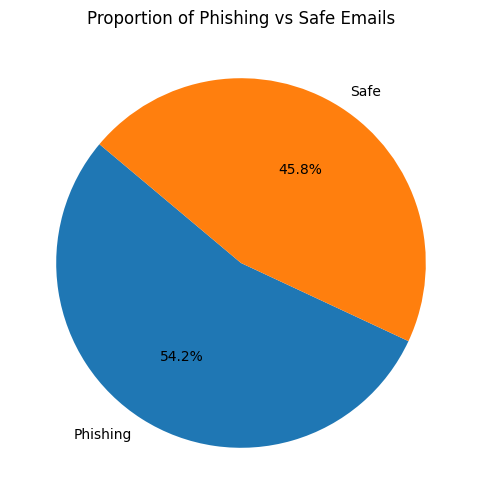

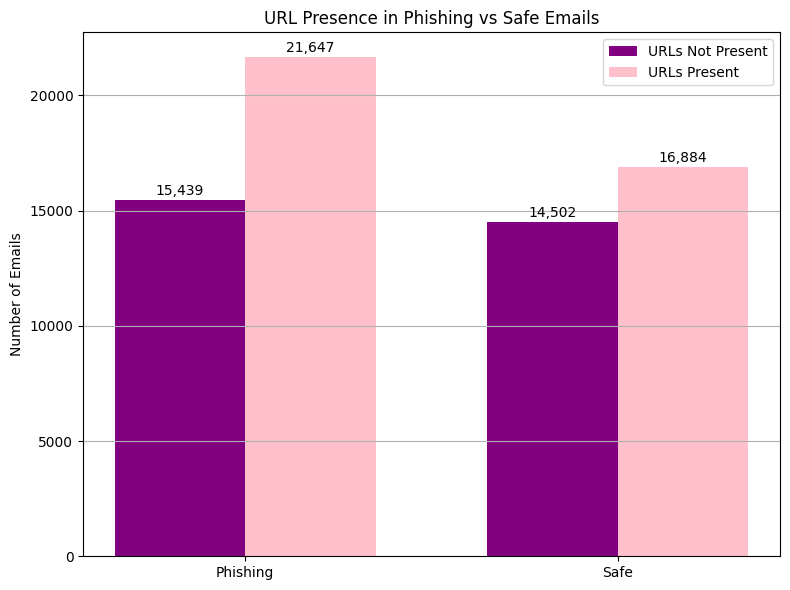

In [ ]:
import matplotlib.pyplot as plt

"""PLOT PIE CHART OF PHISHING VS SAFE EMAILS"""

#Data
labels = ['Phishing', 'Safe']
values = [full_df['label'].value_counts()[1], full_df['label'].value_counts()[0]]

#Plot
plt.figure(figsize=(8, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Phishing vs Safe Emails')
plt.show()



"""PLOT BAR GRAPH OF URLS"""

#Count combinations of label and url presence
group_counts = full_df.groupby(['label', 'urls']).size().unstack(fill_value=0)

#Data
labels = ['Phishing', 'Safe']  # label 1 = Phishing, 0 = Safe
with_urls = [group_counts.loc[1, 1], group_counts.loc[0, 1]]
without_urls = [group_counts.loc[1, 0], group_counts.loc[0, 0]]

x = range(len(labels))  # [0, 1]
bar_width = 0.35

#Plot bars
plt.figure(figsize=(8, 6))
bars1 = plt.bar([i - bar_width/2 for i in x], without_urls, width=bar_width, label='URLs Not Present', color='purple')
bars2 = plt.bar([i + bar_width/2 for i in x], with_urls, width=bar_width, label='URLs Present', color='pink')

#Add value labels on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 100, f'{height:,}',  # add comma to large numbers
                 ha='center', va='bottom', fontsize=10)

#Formatting
plt.xticks(x, labels)
plt.ylabel('Number of Emails')
plt.title('URL Presence in Phishing vs Safe Emails')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()



---
# **Tokenize the training, validation, and testing bodies**
We are now tokenizing the data that we have previously split.

We are creating classes that define how to tokenize the data but this will not actually occur until the BERT model is used. The class highlights the main functionality:


**Initialization**: Initialize the dataset with text data, URLs, labels, and tokenizer.

        Args:
        - texts (List[str]): List of email bodies.
        - urls (List[str] or similar): Corresponding list of URLs in the emails.
        - labels (List[int]): Labels (e.g., 0 for ham, 1 for phishing).
        - tokenizer (BertTokenizer): Pretrained BERT tokenizer.
        - max_length (int): Maximum sequence length for padding/truncation.


**Retrival/Tokenization:** Retrieve a single sample from the dataset and tokenize it.

        Args:
        - idx (int): Index of the sample to fetch.

        Returns:
        - A dictionary containing:
          - 'input_ids': token IDs for the text
          - 'attention_mask': binary mask for padded tokens
          - 'urls': original URL
          - 'labels': ground truth label
       

In [ ]:
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer

#Load the pretrained BERT tokenizer (lowercase version of BERT)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#Define a custom dataset class for phishing email detection
class PhishingEmailDataset(Dataset):
    def __init__(self, texts, urls, labels, tokenizer, max_length=128):
        #Initialize the dataset with text data, URLs, labels, and tokenizer.
        self.texts = texts
        self.urls = urls
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        #Return the total number of samples in the dataset
        return len(self.texts)

    def __getitem__(self, idx):

        #Retrieve a single sample from the dataset and tokenize it.

        encoding = self.tokenizer(
            self.texts[idx],              #The email body
            truncation=True,             #Truncate if it exceeds max_length
            padding='max_length',        #Pad to max_length
            max_length=self.max_length,  #Set max sequence length
            return_tensors='pt'          #Return PyTorch tensors
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),            #Token IDs (squeezed to remove extra dimension)
            'attention_mask': encoding['attention_mask'].squeeze(),  #Attention mask (squeezed)
            'urls': self.urls[idx],                                  #Corresponding URL
            'labels': self.labels[idx]                               #Label for classification
        }

#These assume you have train_bodies, train_urls, and train_labels already defined
train_dataset = PhishingEmailDataset(train_bodies, train_urls, train_labels, tokenizer)
val_dataset   = PhishingEmailDataset(val_bodies, val_urls, val_labels, tokenizer)
test_dataset  = PhishingEmailDataset(test_bodies, test_urls, test_labels, tokenizer)


batch_size = 8  #Number of samples per batch

#For training
train_loader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)

#For validation and testing
val_loader = DataLoader(
    val_dataset,
    sampler=RandomSampler(val_dataset),
    batch_size=batch_size
)

test_loader = DataLoader(
    test_dataset,
    sampler=RandomSampler(test_dataset),
    batch_size=batch_size
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

---
# **Converting the Tokenized Data to Complete Tensors**


# Tokenization for Logisitic Regression

This implementation of tokenization will be used specifically for the logistic regression model. The implementation steps include:
  1. Vectorizing the sentences
  2. Counting the occurances of words
  3. Vectorizing the numbers for the corresponding words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,3))

train_bow = vectorizer.fit_transform(train_bodies)
val_bow = vectorizer.transform(val_bodies)
test_bow = vectorizer.transform(test_bodies)

# **Implementing the Logistic Regression Model**
Logistic Regression is a widely used supervised learning algorithm for binary classification tasks. We use Logistic Regression as a baseline classifier for phishing email detection, using Bag-of-Words (BoW) features extracted from the dataset. This helps us establish a reference accuracy before using more complex models like BERT.

In the code:
- The model is trained on the BoW training data
- We calculate the following statistics to ensure that the model is working and correctly classifying the emails as safe and phishing:
  - Validation Accuracy
  - Confusion Matrix
  - Accuracy
  - Precision
  - Recall
  - F1 Score

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [ ]:
# Initialize Logistic Regression with suitable parameters
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model on Bag-of-Words training data
log_reg.fit(train_bow, train_labels.numpy())

# Predict on validation set
val_preds = log_reg.predict(val_bow)

# Calculate validation accuracy
val_accuracy = accuracy_score(val_labels.numpy(), val_preds)
print(f"Validation Accuracy (Logistic Regression Baseline): {val_accuracy * 100:.2f}%")

Validation Accuracy (Logistic Regression Baseline): 98.16%


[[4458  475]
 [ 133 5206]]
Accuracy: 0.940809968847352


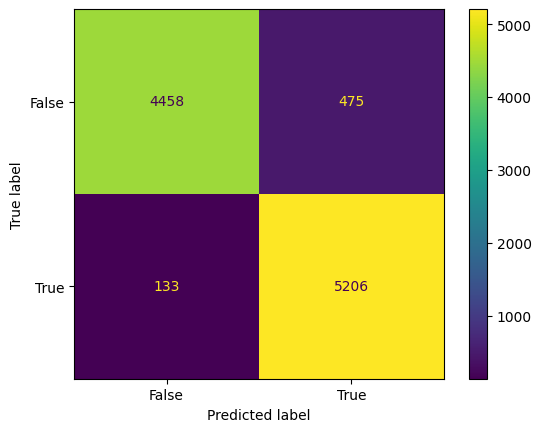

Precision: 0.9163879598662207
Recall: 0.9750889679715302
F1 Score: 0.9448275862068964


In [ ]:
baselineModel = LogisticRegression(max_iter=1000, random_state=0)

baselineModel.fit(train_bow, train_labels) #train the model

prediction = baselineModel.predict(test_bow) #predict class labels for samples in test dataset

#compute confusion matrix
confusionMatrix = confusion_matrix(test_labels, prediction)
print(confusionMatrix)

#compute accuracy
accuracy = (confusionMatrix[1][1] + confusionMatrix[0][0])/(confusionMatrix[1][1] + confusionMatrix[0][0] + confusionMatrix[0][1] + confusionMatrix[1][0])
print(f"Accuracy: {accuracy}")

#plot confusion matrix representation
display = ConfusionMatrixDisplay(confusion_matrix = confusionMatrix, display_labels=[False, True])
display.plot()
plt.show()

#compute precision
precision = confusionMatrix[1][1]/(confusionMatrix[1][1] + confusionMatrix[0][1])
print(f"Precision: {precision}")

#compute recall
recall = confusionMatrix[1][1]/(confusionMatrix[1][1] + confusionMatrix[1][0])
print(f"Recall: {recall}")

#compute F1 score
f1 = 2*(precision*recall)/(precision + recall)
print(f"F1 Score: {f1}")

---
#**Apply Pretrained BERT Model**

- Initialize Pretrained BERT Model Transformer howver make a custom classifier
- Use AdamW Optimizer for optimization and loss
- Define Dataloaders from tensors
- Train the Model
- Use Early Stopping in pretrained model

In [ ]:

import torch.nn as nn
from transformers import DistilBertModel, DistilBertTokenizer

#using distil bert to reduce over fitting
class DistilBertClassifier(nn.Module):
    def __init__(self, dropout_rate=0.3, num_labels=2):
        super(DistilBertClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state[:, 0]  # Take [CLS] token
        dropped = self.dropout(hidden_state)
        logits = self.classifier(dropped)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)  # label smoothing added
            loss = loss_fn(logits, labels)

        return {'loss': loss, 'logits': logits}



In [ ]:

#Instantiate model
model = DistilBertClassifier(dropout_rate=0.3, num_labels=2).to(bert_device)

from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

epochs = 3
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=2e-5)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

best_val_error = float('inf')
patience = 2
patience_counter = 0

train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []
train_err_list = []
val_err_list = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    total_train_err = 0

    for step, batch in enumerate(train_loader):
        b_input_ids = batch['input_ids'].to(bert_device)
        b_attention_mask = batch['attention_mask'].to(bert_device)
        b_labels = batch['labels'].to(bert_device)

        optimizer.zero_grad()
        outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        loss = outputs['loss']
        logits = outputs['logits']

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()
        preds = logits.argmax(dim=1)
        total_train_err += (preds != b_labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_error = total_train_err / len(train_loader.dataset)
    train_accuracy = 1 - train_error

    train_loss_list.append(avg_train_loss)
    train_err_list.append(train_error)
    train_acc_list.append(train_accuracy)

    model.eval()
    total_val_loss = 0
    total_val_err = 0

    with torch.no_grad():
        for batch in val_loader:
            b_input_ids = batch['input_ids'].to(bert_device)
            b_attention_mask = batch['attention_mask'].to(bert_device)
            b_labels = batch['labels'].to(bert_device)

            outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
            loss = outputs['loss']
            logits = outputs['logits']

            total_val_loss += loss.item()
            preds = logits.argmax(dim=1)
            total_val_err += (preds != b_labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_error = total_val_err / len(val_loader.dataset)
    val_accuracy = 1 - val_error

    val_loss_list.append(avg_val_loss)
    val_err_list.append(val_error)
    val_acc_list.append(val_accuracy)

    print(f"Epoch {epoch+1}: Train loss = {avg_train_loss:.4f}, Val loss = {avg_val_loss:.4f}, Train error = {train_error:.4f}, Val error = {val_error:.4f}")

    if val_error < best_val_error:
        best_val_error = val_error
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1: Train loss = 0.2700, Val loss = 0.2233, Train error = 0.0465, Val error = 0.0166
Epoch 2: Train loss = 0.2136, Val loss = 0.2146, Train error = 0.0083, Val error = 0.0099
Epoch 3: Train loss = 0.2063, Val loss = 0.2129, Train error = 0.0047, Val error = 0.0092


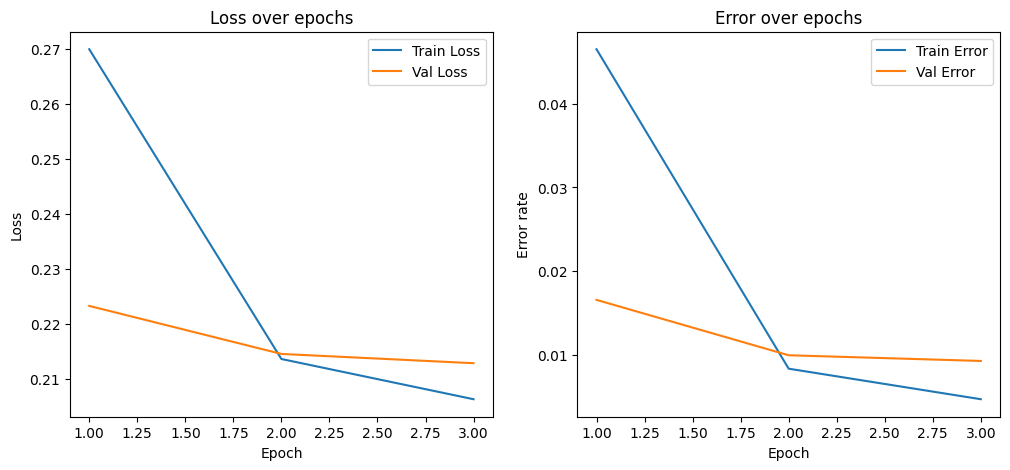

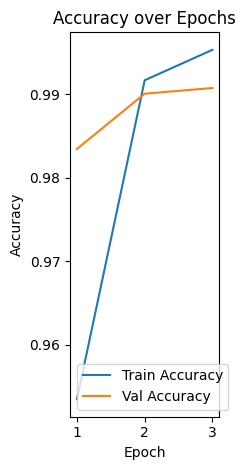

Final Train Accuracy: 99.53%
Final Val Accuracy: 99.08%


In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12,5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_list, label='Train Loss')
plt.plot(epochs_range, val_loss_list, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()

# Plot error
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_err_list, label='Train Error')
plt.plot(epochs_range, val_err_list, label='Val Error')
plt.xlabel('Epoch')
plt.ylabel('Error rate')
plt.title('Error over epochs')
plt.legend()

plt.show()


# Plot Accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_acc_list, label='Train Accuracy')
plt.plot(epochs_range, val_acc_list, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Final Train Accuracy: {train_acc_list[-1]*100:.2f}%")
print(f"Final Val Accuracy: {val_acc_list[-1]*100:.2f}%")


In [ ]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(bert_device)
        attention_mask = batch['attention_mask'].to(bert_device)
        labels = batch['labels'].to(bert_device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs['logits']
        preds = logits.argmax(dim=1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())


In [ ]:
import numpy as np

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

false_positives = np.sum((all_preds == 1) & (all_labels == 0))
false_negatives = np.sum((all_preds == 0) & (all_labels == 1))

total_samples = len(all_labels)

fp_percent = 100 * false_positives / total_samples
fn_percent = 100 * false_negatives / total_samples

print(f"False Positives: ({fp_percent:.2f}%)")
print(f"False Negatives: ({fn_percent:.2f}%)")


False Positives: (0.59%)
False Negatives: (0.33%)


---
#Evaluation
Testing

In [ ]:
# Load the best model
model.load_state_dict(torch.load('best_model.pt'))
model.eval()


DistilBertClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L

In [ ]:
total_test_err = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        b_input_ids = batch['input_ids'].to(bert_device)
        b_attention_mask = batch['attention_mask'].to(bert_device)
        b_labels = batch['labels'].to(bert_device)

        outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        logits = outputs['logits']

        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())

        total_test_err += (preds != b_labels).sum().item()

test_error = total_test_err / len(test_loader.dataset)
test_accuracy = 1 - test_error

print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9390


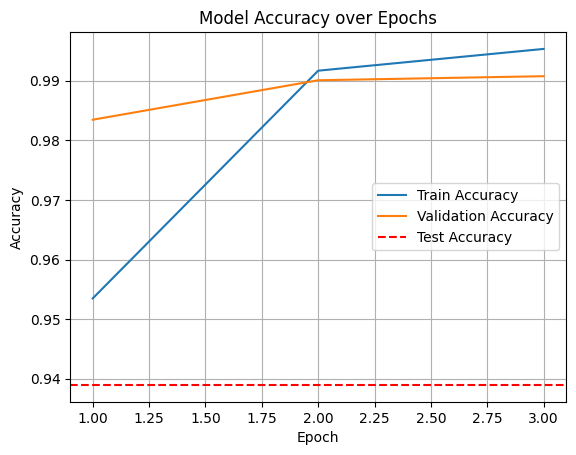

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_acc_list) + 1)

plt.plot(epochs_range, train_acc_list, label='Train Accuracy')
plt.plot(epochs_range, val_acc_list, label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='red', linestyle='--', label='Test Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

False Positives: 449 (4.37%)
False Negatives: 178 (1.73%)
BERT Accuracy: 0.9389602803738317


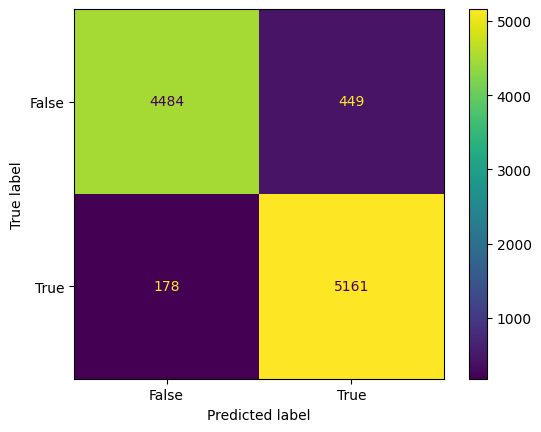

BERT Precision: 0.919964349376114
BERT Recall: 0.9666604233002435
BERT F1 Score: 0.9448275862068964


In [ ]:
from sklearn.metrics import confusion_matrix

# Create confusion matrix from labels and predictions
cm = confusion_matrix(all_labels, all_preds)

# Assuming binary classification: cm = [[TN, FP], [FN, TP]]
tn, fp, fn, tp = cm.ravel()

total_samples = len(all_labels)

# Calculate percentages
false_positive_pct = (fp / total_samples) * 100
false_negative_pct = (fn / total_samples) * 100

print(f"False Positives: {fp} ({false_positive_pct:.2f}%)")
print(f"False Negatives: {fn} ({false_negative_pct:.2f}%)")

#compute accuracy
accuracy_BERT = (cm[1][1] + cm[0][0])/(cm[1][1] + cm[0][0] + cm[0][1] + cm[1][0])
print(f"BERT Accuracy: {accuracy_BERT}")

#plot confusion matrix representation
display_BERT = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=[False, True])
display_BERT.plot()
plt.show()

#compute precision
precision_BERT = cm[1][1]/(cm[1][1] + cm[0][1])
print(f"BERT Precision: {precision_BERT}")

#compute recall
recall_BERT = cm[1][1]/(cm[1][1] + cm[1][0])
print(f"BERT Recall: {recall_BERT}")

#compute F1 score
f1_BERT = 2*(precision_BERT*recall_BERT)/(precision_BERT + recall_BERT)
print(f"BERT F1 Score: {f1}")


In [ ]:
def predict_email(model, tokenizer, text, device):
    model.eval()

    # Tokenize input
    inputs = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(device)

    # Remove token_type_ids if it exists
    if "token_type_ids" in inputs:
        inputs.pop("token_type_ids")

    with torch.no_grad():
        #pass tokenized inputs through model to get the outputs
        outputs = model(**inputs)
        #extract logits from model output
        logits = outputs['logits'] if isinstance(outputs, dict) else outputs
        #apply softmax to logits from model to convert them into prob. scores for phishing/non phishing
        probs = torch.nn.functional.softmax(logits, dim=1)
        #determine which class the result belongs in
        predicted_class = torch.argmax(probs, dim=1).item()
        confidence = probs.squeeze().tolist()

    #convert class labels into human readable format
    label_map = {0: "Not Phishing", 1: "Phishing"}

    print(f"Prediction: {label_map[predicted_class]}")
    print(f"Confidence Scores: \nNot Phishing- {confidence[0]*100:.2f}% \nPhishing- {confidence[1]*100:.2f}%")

    return predicted_class, confidence


In [ ]:
#Example with real phishing mail from my father's inbox (not in test eval dataset)
email_text = "From: Ms.Kadulina <gutierrezmm@cvh.edu.mx> Date: Wed, Jul 23, 2025 at 11:01 AM Subject: Awaiting Your Response To: Recipients <gutierrezmm@cvh.edu.mx> I'm Yulia Kadulina from Ukrsibbank Ukraine.I have an urgent opportunity for you that would be of great benefits. Please Get back ASAP. Thanks, Ms.Kadulina"

predict_email(model, tokenizer, email_text, bert_device)



Prediction: Phishing
Confidence Scores: 
Not Phishing: 3.87% 
Phishing: 96.13%


(1, [0.038727886974811554, 0.9612720608711243])

In [ ]:
#Example with real non-phishing mail from my from my mom inbox (not in test eval dataset)

email_text = "From: Rajeshwari Sarkar <rajeshwari.sarkar@gmail.com> Date: Sun, Mar 23 2025 at 2:16 PM Subject: Update Resume The resume Raj Sarkar is my existing one. I need to put it in a format that focuses on skills rather than experience. Example attached. My skills Are Cloud Transformation , Vendor Management , Azure - Databricks - Snowflake , "
predict_email(model, tokenizer, email_text, bert_device)


Prediction: Not Phishing
Confidence Scores: 
Not Phishing: 68.81% 
Phishing: 31.19%


(0, [0.6880588531494141, 0.31194111704826355])

# Cleaning up RAM usage **(Place this block at the bottom of the code for now please)**
We are going to clean up some data to prevent high usage of memory. Please note, you can only run this cell once if you don't reinstantiate these variables

In [ ]:
import gc

del train_urls, val_urls, test_urls
del train_labels, val_labels, test_labels
del train_dataset, val_dataset, test_dataset
del train_loader, val_loader, test_loader

gc.collect()

10037